In [1]:
import sys
import math
from collections import defaultdict
from collections import Counter

import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import peakutils
import ltfatpy

import note as notepy
import rion


In [47]:
# Interactive inline plots
%matplotlib notebook

In [2]:
# Static inline plots
%matplotlib inline

In [2]:
# Interactive windowed plots
%matplotlib qt

# Sample Import and Preprocess
In these snippets, we import a sample of a piano playing an Ab3/G\#3, recorded through a phone mic.

Text(0,0.5,'Volume')

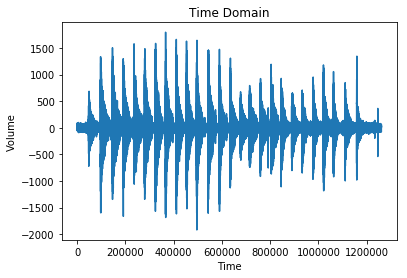

In [3]:
# Load sample
sample_file = 'samples/Intervals_C.wav'
fs, x = scipy.io.wavfile.read(sample_file)

plt.plot(x)
plt.title('Time Domain')
plt.xlabel('Time')
plt.ylabel('Volume')


Text(0,0.5,'Volume')

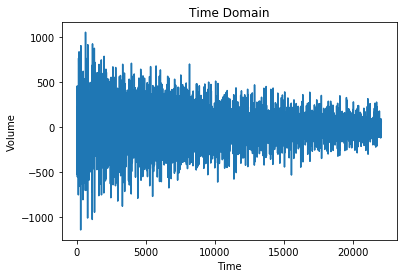

In [4]:
# Cut sample
x = x[100000:122050]

plt.plot(x)
plt.title('Time Domain')
plt.xlabel('Time')
plt.ylabel('Volume')


# Note Detection
Here, we run a filter on the frequency domain to gather the strength of each note in the timbre.

## Look at Frequency Domain

(0, 5000)

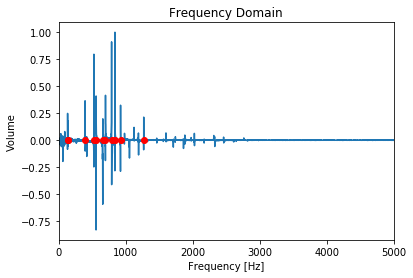

In [8]:
# Take a look at the frequency domain
X = np.real(np.fft.fft(x))
X = X/np.max(X)

peaks = peakutils.indexes(X, thres=0.55/max(X), min_dist=5)

plt.plot(X)
plt.plot(peaks, np.zeros(len(peaks)), 'ro')
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Volume')
plt.xlim([0,5000])


## Frequency Domain Peaks
Find the peaks in the frequency domain. Those are the notes.

In [6]:
magnitudes, notes = rion.get_notes(x, fs)

print('Notes in timbre, and their magnitudes:')
for magnitude, note, in zip(magnitudes, notes):
    print('{}:\t{:.2f}'.format(note,magnitude))


Notes in timbre, and their magnitudes:
C2+0.02:	0.30
C#2-0.07:	0.17
G3:	0.38
C4+0.02:	1.08
C#4+0.08:	0.39
E4-0.06:	0.36
F4-0.04:	0.38
G4+0.09:	0.57
G#4+0.15:	1.00
Bb4-0.19:	0.21
C#5+0.22:	0.09
Eb5+0.32:	0.21


## Note Buckets
We created a filter which gets the average volume for each note from the frequency domain.

(0.5, 100.5)

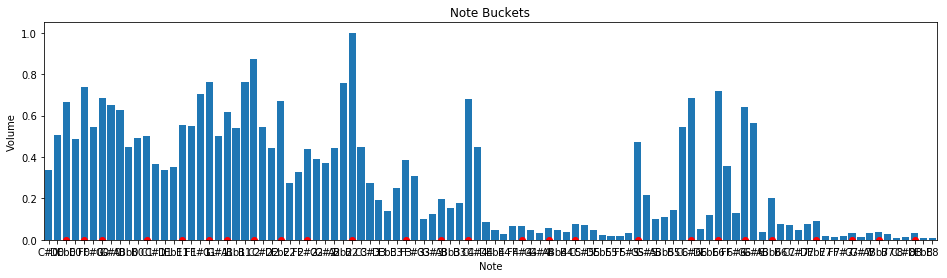

In [9]:
# Put X into note buckets
note_buckets, notes = rion.note_filter(x, fs)
note_buckets = note_buckets / np.max(note_buckets)
note_names = [note.name + str(note.octave) for note in notes]

# TODO: Thresholding might work better for note clusters
# Get loud notes
peaks = peakutils.indexes(note_buckets, thres=0.02/max(note_buckets), min_dist=1)

plt.figure(figsize = (16,4))
plt.bar(np.arange(len(note_buckets)), note_buckets)
plt.plot(peaks, np.zeros(len(peaks)), 'ro')
plt.title('Note Buckets')
plt.xlabel('Note')
plt.ylabel('Volume')
plt.xticks(np.arange(len(notes)), note_names)
plt.xlim([peaks[0]-2.5,peaks[-1]+2.5])


## Note stats
An example of some statistics that can be gathered from our note filter.


In [10]:
# Get peak notes
peak_notes = [notes[peak] for peak in peaks]
print('Notes in timbre are {}\n'.format([str(peak_note) for peak_note in peak_notes]))
f_0 = peak_notes[0]
print('f_0 is {}\n'.format(f_0))

# Peak tone count
print('Timbre tone count:')
peak_tones = dict(Counter([peak_note.name for peak_note in peak_notes]))
for w in sorted(peak_tones, key=peak_tones.get, reverse=True):
    print('{}\t{}'.format(w, peak_tones[w]))

# Sum of tone strengths
print('\nSum of tone strengths:')
tone_sums = defaultdict(int)
for note, vol in zip(notes, note_buckets):
    tone_sums[note.name] += vol
for w in sorted(tone_sums, key=tone_sums.get, reverse=True):
    print('{}\t{}'.format(w, round(tone_sums[w],3)))


Notes in timbre are ['Eb0', 'F0', 'G0', 'C1', 'E1', 'G1', 'A1', 'C2', 'Eb2', 'F#2', 'B2', 'F3', 'A3', 'C4', 'F#4', 'A4', 'C5', 'G5', 'C#6', 'E6', 'G6', 'Bb6', 'Eb7', 'G7', 'Bb7', 'D8']

f_0 is Eb0

Timbre tone count:
G	5
C	4
Eb	3
A	3
F	2
E	2
F#	2
Bb	2
B	1
C#	1
D	1

Sum of tone strengths:
C	3.81
G	3.138
C#	2.799
B	2.723
G#	2.481
F	2.466
E	2.362
Bb	2.304
F#	2.255
A	2.119
Eb	2.117
D	1.768


### Timbre Filter
This is a filter of the timbre of a a note. It has the strength of different harmonics with the 0th index storing the strength of the fundamental frequency, and each following index is a semitone higher.

Todo: test if the timbre of an instrument changes in different octaves.

In [ ]:
# Set semitones which are noise to zero
for i in range(len(note_buckets)):
    if i not in peaks:
        note_buckets[i] = 0

timbre_filter = note_buckets[peaks[0]:peaks[-1]+1]

plt.bar(np.arange(len(timbre_filter)), timbre_filter)
plt.title('Timbre Filter')
plt.xlabel('Pitch (semitones above f_0)')
plt.ylabel('Volume')

# Multiple Note Detection
We can use the note buckets and timbre filter to detect multiple notes.
## Import Sample

In [ ]:
# Load sample
sample_file = 'samples/piano_Am4_chord.wav'
fs, x = scipy.io.wavfile.read(sample_file)

# Cut samples
x = x[25000:25000+fs]

plt.plot(x)
plt.title('Time Domain')
plt.xlabel('Time')
plt.ylabel('Volume')


In [ ]:
# Put X into note buckets
note_buckets, notes = rion.note_filter(x, fs)
note_buckets = note_buckets / np.max(note_buckets)
note_names = [note.name + str(note.octave) for note in notes]

# TODO: Thresholding might work better for note clusters
# Get loud notes
peaks = peakutils.indexes(note_buckets, thres=0.02/max(note_buckets), min_dist=1)

plt.figure(figsize = (16,4))
plt.bar(np.arange(len(note_buckets)), note_buckets)
plt.plot(peaks, np.zeros(len(peaks)), 'ro')
plt.title('Note Buckets')
plt.xlabel('Note')
plt.ylabel('Volume')
plt.xticks(np.arange(len(notes)), note_names)

# Pitch Detection via Spectrogram (work in progress)

In [ ]:
window = scipy.signal.get_window('triang', 2048)
f, t, Sxx = scipy.signal.spectrogram(x, fs, window=window)
plt.pcolormesh(t, f, Sxx)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
